In [254]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic.plotting import plot_model
from diffractio.scalar_sources_XY import Scalar_source_XY
%matplotlib ipympl

In [255]:
def zero_phase(u, idx_x, idx_y):
    u_centre = u[idx_x, idx_y]
    phase_difference =  0 - np.angle(u_centre)
    u = u * np.exp(1j * phase_difference)
    
    return u

def make_detector_for_gauss_rays(x_det, y_det, n_rays):
    x,y = np.meshgrid(x_det, y_det)
    
    r = np.array([x.ravel(), y.ravel()]).T
    r = np.broadcast_to(r, [n_rays, *r.shape])
    r = np.swapaxes(r, 0, 1)

    return r

def abssqr(x):
    return np.real(x*np.conj(x))

def FT(x):
    return np.fft.fftshift(np.fft.fft2(x))

def iFT(x):
    return np.fft.ifft2(np.fft.ifftshift(x))
    
def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    n, m = E0.shape

    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)
    
    H = np.exp(-1j * (2 * np.pi / lambda0) * z) * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    E0fft = np.fft.fft2(E0)
    G = H * E0fft
    Ef = np.fft.ifft2(G)
    
    return Ef

def lens_phase_factor(n, ps, lambda0, f):
    """
    Compute the phase factor introduced by an ideal lens.
    
    Parameters:
        n : int
            Number of pixels (assuming square grid, n x n).
        ps : float
            Pixel size (in the same units as wavelength and focal length).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        f : float
            focal length of the lens (in the same units as ps).
    
    Returns:
        phase_factor : 2D array (n x n)
            The phase factor to multiply with the field.
    """
    x = np.linspace(-n/2, n/2 - 1, n) * ps
    y = np.linspace(-n/2, n/2 - 1, n) * ps
    X, Y = np.meshgrid(x, y)
    
    phase_factor = np.exp(-1j * np.pi * (X**2 + Y**2) / (lambda0 * f) + 1j * np.pi)
    
    return phase_factor

In [256]:
n_rays = 1
wavelength = 0.01
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)


size = 512
det_shape = (size, size)
pixel_size = 0.005
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

wo = 0.1
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

theta_x = 5
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

x0 = -0.2
y0 = 0

lens_dist = 1
focal = 0.7
prop_dist = 1

In [257]:
components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    comp.Lens(
        z = lens_dist,
        f = focal,
    ),
    comp.AccumulatingDetector(
        z = lens_dist + prop_dist,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
    ),
)

In [258]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays, random = False))
gbd_output_field = model.detector.get_image(rays[-1])

gbd_output_field= zero_phase(gbd_output_field, size//2, size//2)

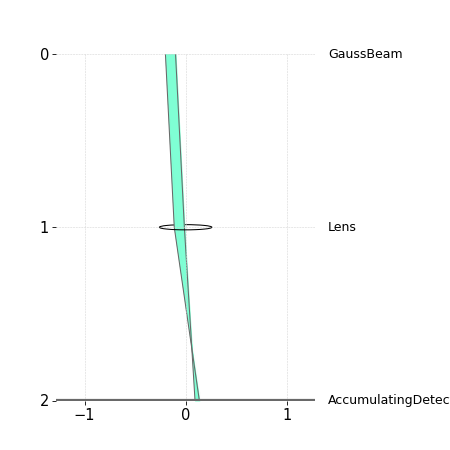

In [259]:
fig, ax = plot_model(model)

Text(0.5, 0.98, 'GBD')

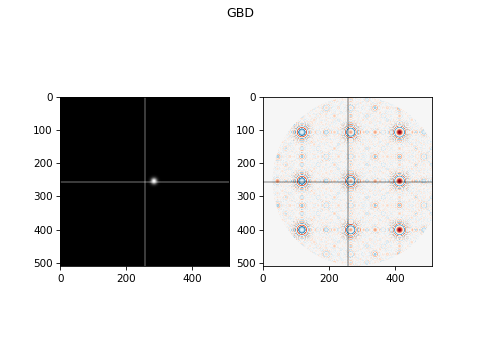

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(gbd_output_field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(gbd_output_field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBD")

In [261]:
# Calculate theta and phi
tan_theta_x = np.tan(deg_yx[1])
tan_theta_y = np.tan(deg_yx[0])

theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
phi = np.arctan2(tan_theta_y, tan_theta_x)

fresnel_input_field = Scalar_source_XY(x=x_det, y=x_det, wavelength=wavelength)
fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, lens_dist)
fresnel_output_field = fresnel_output_field * lens_phase_factor(size, pixel_size, wavelength, focal)
fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, prop_dist)
fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

Text(0.5, 0.98, 'Fresnel')

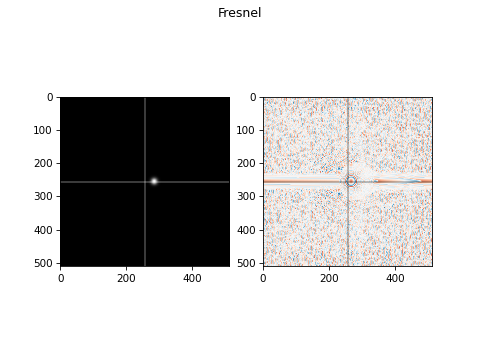

In [262]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(fresnel_output_field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(fresnel_output_field ),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("Fresnel")

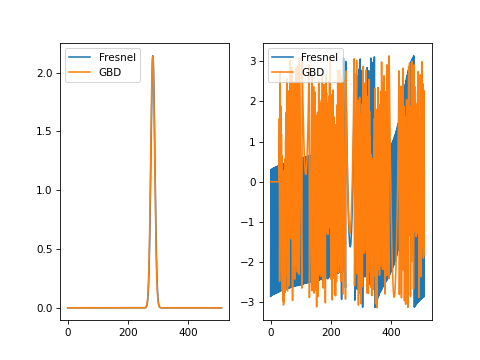

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2)
s = np.s_[size // 2, :]
ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel")
ax1.plot(np.abs(gbd_output_field[s]), label="GBD")
ax1.legend()
ax2.plot(np.angle(fresnel_output_field[s]), label="Fresnel")
ax2.plot(np.angle(gbd_output_field[s]), label="GBD")
ax2.legend()

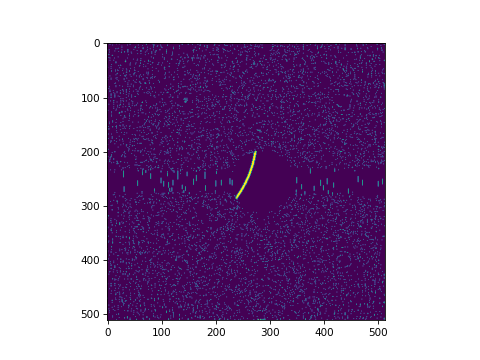

In [264]:
fig, ax1 = plt.subplots()
ax1.imshow(
    np.isclose(
        np.angle(gbd_output_field),
        np.angle(fresnel_output_field),
        atol=0.1,
    )
)